## Import Statements

In [1]:
import gc
import os
import sys
import random
import pickle
import bisect
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

os.environ["CDF_LIB"] = "/usr/local/lib/cdf/lib/"
import netCDF4 as nc
import pyspedas
from spacepy import pycdf
from pyspedas import wind
from pytplot import tplot, get_data

## Various functions

In [2]:
# Constants
e = 1.602176634e-19
m = 9.109383701528e-31
e_0 = 8.854187812813e-12
cons = e/((m*e_0)**.5)/(2*np.pi)
print(e**2/(e_0*m))
print(cons)

3182.6073539848016
8.978662820467044


In [3]:
def find_closest_time(time, lst):
    return min(range(len(lst)), 
               key=lambda i: abs(time-lst[i]))

def reduced_time_closest_time(goal_time, time_lst):
    """
    Find the index in the availible times which is closest to the goal time
    """
    # Bisect gives the index of the smallest value which is greater than goal time
    upper_index = min(bisect.bisect_left(time_lst, goal_time), len(time_lst)-1)
    lower_index = max(upper_index-1, 0)
    if abs(time_lst[upper_index] - goal_time) > abs(time_lst[lower_index] - goal_time):
        return lower_index
    else:
        return upper_index

def conv_dens_to_freq(ne):
    assert ne>=0
    return ne**.5 * cons

def norm(lst, max_val):
    return np.array([val/max_val for val in lst])

def denorm(lst, max_val):
    return np.array([val*max_val for val in lst])

def print_lst(lst, sort=False):
    if sort:
        lst.sort()
    print("[")
    for n in lst:
        print(f"{repr(n)},")
    print("]")

def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)


## Importing Data

### pySPEDAS

In [34]:
wind.threedp(datatype='3dp_elpd')

18-Aug-22 16:39:14: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/wind/3dp/3dp_elpd/1999/
18-Aug-22 16:39:15: Downloading https://spdf.gsfc.nasa.gov/pub/data/wind/3dp/3dp_elpd/1999/wi_elpd_3dp_19991105_v02.cdf to wind_data/3dp/3dp_elpd/1999/wi_elpd_3dp_19991105_v02.cdf
18-Aug-22 16:39:15: Download complete: wind_data/3dp/3dp_elpd/1999/wi_elpd_3dp_19991105_v02.cdf


[]

In [26]:
wind.threedp(trange=['1995-06-01', '1995-06-27'], datatype='3dp_ehpd')


18-Aug-22 16:37:49: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/wind/3dp/3dp_ehpd/1995/
18-Aug-22 16:37:50: File is current: wind_data/3dp/3dp_ehpd/1995/wi_ehpd_3dp_19950601_v02.cdf
18-Aug-22 16:37:50: File is current: wind_data/3dp/3dp_ehpd/1995/wi_ehpd_3dp_19950602_v02.cdf
18-Aug-22 16:37:50: File is current: wind_data/3dp/3dp_ehpd/1995/wi_ehpd_3dp_19950603_v02.cdf
18-Aug-22 16:37:51: File is current: wind_data/3dp/3dp_ehpd/1995/wi_ehpd_3dp_19950604_v02.cdf
18-Aug-22 16:37:51: File is current: wind_data/3dp/3dp_ehpd/1995/wi_ehpd_3dp_19950605_v02.cdf
18-Aug-22 16:37:52: File is current: wind_data/3dp/3dp_ehpd/1995/wi_ehpd_3dp_19950606_v02.cdf
18-Aug-22 16:37:52: File is current: wind_data/3dp/3dp_ehpd/1995/wi_ehpd_3dp_19950607_v02.cdf
18-Aug-22 16:37:53: File is current: wind_data/3dp/3dp_ehpd/1995/wi_ehpd_3dp_19950608_v02.cdf
18-Aug-22 16:37:54: File is current: wind_data/3dp/3dp_ehpd/1995/wi_ehpd_3dp_19950609_v02.cdf
18-Aug-22 16:37:54: File is current: wind_data/3

[]

In [27]:
len(get_data('VSW').y)

That name is currently not in pytplot


AttributeError: 'NoneType' object has no attribute 'y'

In [25]:
wind.swe(trange=['1995-06-01', '1995-06-27'], datatype='h0')
wind.swe(trange=['1995-06-01', '1995-06-27'], datatype='k0')

18-Aug-22 16:37:02: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/wind/swe/swe_h0/1995/
18-Aug-22 16:37:03: File is current: wind_data/swe/swe_h0/1995/wi_h0_swe_19950601_v02.cdf
18-Aug-22 16:37:03: File is current: wind_data/swe/swe_h0/1995/wi_h0_swe_19950602_v02.cdf
18-Aug-22 16:37:04: File is current: wind_data/swe/swe_h0/1995/wi_h0_swe_19950603_v02.cdf
18-Aug-22 16:37:05: File is current: wind_data/swe/swe_h0/1995/wi_h0_swe_19950604_v02.cdf
18-Aug-22 16:37:05: File is current: wind_data/swe/swe_h0/1995/wi_h0_swe_19950605_v02.cdf
18-Aug-22 16:37:05: File is current: wind_data/swe/swe_h0/1995/wi_h0_swe_19950606_v02.cdf
18-Aug-22 16:37:06: File is current: wind_data/swe/swe_h0/1995/wi_h0_swe_19950607_v02.cdf
18-Aug-22 16:37:06: File is current: wind_data/swe/swe_h0/1995/wi_h0_swe_19950608_v02.cdf
18-Aug-22 16:37:06: File is current: wind_data/swe/swe_h0/1995/wi_h0_swe_19950609_v02.cdf
18-Aug-22 16:37:07: File is current: wind_data/swe/swe_h0/1995/wi_h0_swe_19950610_v02.

['SC_pos_gse',
 'SC_pos_GSM',
 'SC_pos_R',
 'V_GSE',
 'V_GSM',
 'V_GSE_p',
 'THERMAL_SPD',
 'Np',
 'Alpha_Percent']

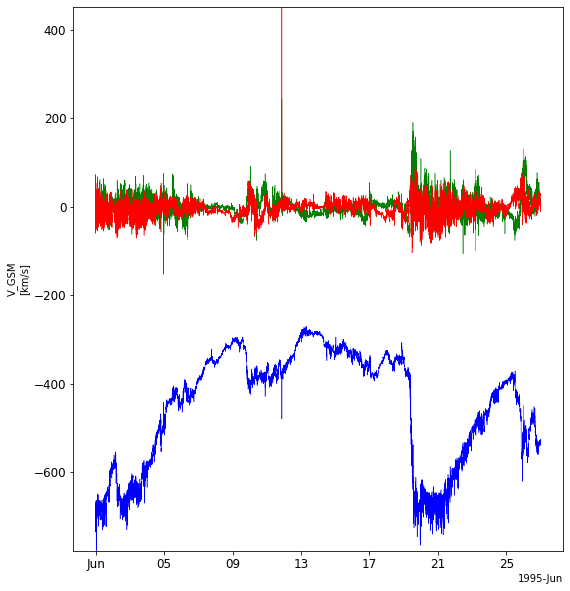

In [17]:
tplot('V_GSM')

In [18]:
pyspedas_data = get_data('Te')

18-Aug-22 10:24:20: /home/ayushmaan/.local/lib/python3.10/site-packages/pytplot/MPLPlotter/tplot.py:230: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  this_axis.set_ylim(yrange)



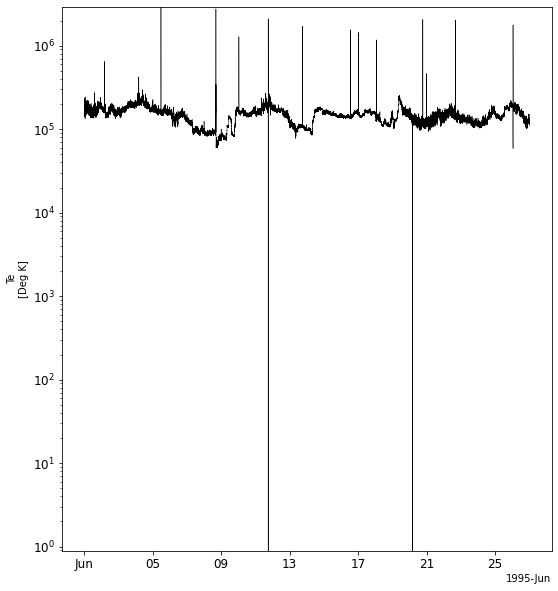

In [19]:
tplot('Te')

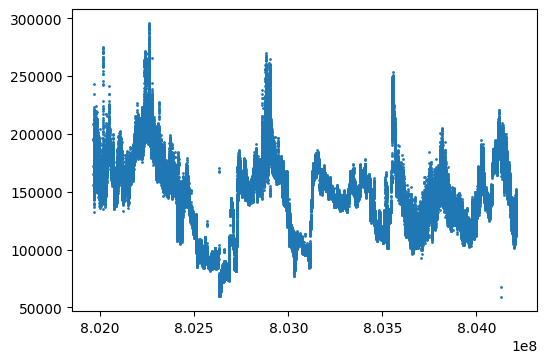

In [20]:
time_te, raw_te = list(zip(*[data for data in filter(lambda lst: lst[1]<3e5 and lst[1]>0,zip(pyspedas_data.times,pyspedas_data.y))]))
fig, ax = plt.subplots(dpi=100)
ax.scatter(time_te,raw_te, s=1)
#ax.scatter(time, te, s=1)
fig.savefig("plots/figure.png")

In [21]:
data = get_data("V_GSM")
raw_vsw = abs(data.y[:,0])
time_vsw = data.times[:]

In [22]:
time_vsw, raw_vsw = list(zip(*[data for data in filter(lambda lst: not np.isnan(lst[1]),zip(time_vsw,raw_vsw))]))


In [23]:
# plt.plot(data.times, (data.y[:,0]**2 + data.y[:,0]**2 +data.y[:,0]**2)**.5, label="V_GSM - sqrt(x^2 + y^2 + z^2)")
# plt.plot(data.times, abs(data.y[:,0]), label="V_GSM - abs(x)")

# plt.axhline(y=750, label="Fast Wind", color='g')
# plt.axhline(y=500, label="Slow Wind Maximum", color='r')
# plt.axhline(y=300, label="Slow Wind Minimum", color='b')
# plt.legend()
# plt.title("Figuring out what to use for solar wind speed")
# plt.xlabel("Epoch Time (s)")
# plt.ylabel("Solar Wind Speed (km/s)")
# plt.savefig("plots/vsw_k0.png")
# print(len(data.times), 26*24*3600/len(data.times))

In [35]:
vsw_folder = "wind_data/3dp/3dp_ehpd/1995/"

vsw_data = [ vsw_folder+file for file in os.listdir(vsw_folder) if file.endswith(".nc")]
vsw_data.sort()

In [26]:
time = []
freq = []
spec = []
time2 = []
raw_fpe = []
raw_electron_density = []
for spectra_file_name, nn_file_name in combined_data:
    date = spectra_file_name[32:-3]
    date_epoch = int(datetime.datetime(int(date[0:4]), int(date[4:6]), int(date[6:8]), 0, 0, 0, 
                                       tzinfo=datetime.timezone.utc).timestamp())
    
    with nc.Dataset(spectra_file_name) as file:
        temp_time = file["tnr_ch1_time"][:]
        temp_spec = file["tnr_ch1_spec"][:]
        if len(freq) == 0:
            freq  = file["tnr_ch1_freq"][:]
    
    with nc.Dataset(nn_file_name) as file:
        temp_time2   = file["Time"][:]
        temp_raw_fpe = file["Plasma Frequency"][:]
        temp_dens    = file["Electron Density"][:]
        
        # Found slight bug where the times over some days are shifted by 86400 seconds up
        if temp_time2[10] >= 86400:
            print(f"Correced: {spectra_file_name}")
            temp_time2 = np.subtract(temp_time2, 86400)
        temp_time2 = np.add(temp_time2, date_epoch)

    if not temp_time[0] in time:
        time.extend(temp_time)
        spec.extend(np.transpose(temp_spec))
        time2.extend(temp_time2)
        raw_fpe.extend(temp_raw_fpe)
        raw_electron_density.extend(temp_dens)
        
    else:
        print(spectra_file_name)
print(len(time))
spec = [s[32:] for s in spec]
print(np.shape(spec))

Correced: data/solaris/1995-06/wi_wav_tnr_19950603.nc
Correced: data/solaris/1995-06/wi_wav_tnr_19950604.nc
Correced: data/solaris/1995-06/wi_wav_tnr_19950611.nc
Correced: data/solaris/1995-06/wi_wav_tnr_19950618.nc
Correced: data/solaris/1995-06/wi_wav_tnr_19950619.nc
505726
(505726, 64)


In [24]:
def remove_ac_band_gap(freq):
    gap = freq[32] - freq[31]
    freq[:32] = [num+gap for num in freq[:32]]
    return freq

### Solaris and CDPP data

In [25]:
spectra_folder = "data/solaris/1995-06/"
nn_folder = "data/cdpp/34069/DA_TC_WIND_WAVES_TNR_L3_NN/"

spectra_data = [ spectra_folder+file for file in os.listdir(spectra_folder) if file.endswith(".nc")]
nn_data = [ nn_folder+file for file in os.listdir(nn_folder) if file.endswith(".nc")]
spectra_data.sort()
nn_data.sort()
combined_data = zip(spectra_data, nn_data)
#print_lst(combined_data)

In [26]:
time = []
freq = []
spec = []
time2 = []
raw_fpe = []
raw_electron_density = []
for spectra_file_name, nn_file_name in combined_data:
    date = spectra_file_name[32:-3]
    date_epoch = int(datetime.datetime(int(date[0:4]), int(date[4:6]), int(date[6:8]), 0, 0, 0, 
                                       tzinfo=datetime.timezone.utc).timestamp())
    
    with nc.Dataset(spectra_file_name) as file:
        temp_time = file["tnr_ch1_time"][:]
        temp_spec = file["tnr_ch1_spec"][:]
        if len(freq) == 0:
            freq  = file["tnr_ch1_freq"][:]
    
    with nc.Dataset(nn_file_name) as file:
        temp_time2   = file["Time"][:]
        temp_raw_fpe = file["Plasma Frequency"][:]
        temp_dens    = file["Electron Density"][:]
        
        # Found slight bug where the times over some days are shifted by 86400 seconds up
        if temp_time2[10] >= 86400:
            print(f"Correced: {spectra_file_name}")
            temp_time2 = np.subtract(temp_time2, 86400)
        temp_time2 = np.add(temp_time2, date_epoch)

    if not temp_time[0] in time:
        time.extend(temp_time)
        spec.extend(np.transpose(temp_spec))
        time2.extend(temp_time2)
        raw_fpe.extend(temp_raw_fpe)
        raw_electron_density.extend(temp_dens)
        
    else:
        print(spectra_file_name)
print(len(time))
spec = [s[32:] for s in spec]
print(np.shape(spec))

Correced: data/solaris/1995-06/wi_wav_tnr_19950603.nc
Correced: data/solaris/1995-06/wi_wav_tnr_19950604.nc
Correced: data/solaris/1995-06/wi_wav_tnr_19950611.nc
Correced: data/solaris/1995-06/wi_wav_tnr_19950618.nc
Correced: data/solaris/1995-06/wi_wav_tnr_19950619.nc
505726
(505726, 64)


In [27]:
# Increase memory efficiency
time2, raw_fpe, raw_electron_density = list(zip(*[d for d in zip(time2, raw_fpe, raw_electron_density) if d[1]>1]))

fpe = [raw_fpe[reduced_time_closest_time(t, time2)] for t in time]
electron_density = [raw_electron_density[reduced_time_closest_time(t, time2)] 
                    for t in time]

vsw = [raw_vsw[reduced_time_closest_time(t, time_vsw)] for t in time]
te = [raw_te[reduced_time_closest_time(t, time_te)] for t in time]
#plt.plot(raw_fpe)

In [28]:
print(np.shape(time), np.shape(spec), np.shape(fpe), np.shape(electron_density), np.shape(te))
data_v1 = list(zip(time, spec, fpe, electron_density, te, vsw))

(505726,) (505726, 64) (505726,) (505726,) (505726,)


## Randomizing and sorting data

In [29]:
random.seed(10)
random_index = list(range(len(data_v1)))
random.shuffle(random_index)
data_v3 = [data_v1[i] for i in random_index]    

In [30]:
max_y = 50 #max([d[2] for d in data_v3])
s = int(len(data_v3)*.9//1)
print(np.shape(data_v3[:s]))


# Takes the training section of the data and unzips the test and training data
train_x_data     = np.array([d[1] for d in data_v3[:s]])
train_y_data     = np.array([d[2]/max_y for d in data_v3[:s]])
train_y_data_ed  = np.array([d[3] for d in data_v3[:s]])
train_y_data_te  =  np.array([d[4] for d in data_v3[:s]])
train_y_data_vsw =  np.array([d[5] for d in data_v3[:s]])
print("Done with creating trainning data")

# Sorts test data so we could use that sorted data to make nice graphs at the end
test_sorted = data_v3[s:]
test_sorted.sort(key=lambda x: x[0])
print("Done sorting")

test_time_sorted = np.array([d[0] for d in test_sorted])
test_x_sorted    = np.array([d[1] for d in test_sorted])
test_y_sorted    = np.array([d[2]/max_y for d in test_sorted])
test_y_sorted_ed = np.array([d[3] for d in test_sorted])
test_y_sorted_te =  np.array([d[4] for d in test_sorted])
test_y_sorted_vsw =  np.array([d[5] for d in test_sorted])

print("Done with creating test data")

18-Aug-22 10:24:34: /home/ayushmaan/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape



(455153, 6)
Done with creating trainning data
Done sorting
Done with creating test data


In [31]:
for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))


                  train_x_data: 222.2 MiB
                 test_x_sorted: 24.7 MiB
                          time:  4.3 MiB
                          spec:  4.0 MiB
                           fpe:  4.0 MiB
              electron_density:  4.0 MiB
                           vsw:  4.0 MiB
                            te:  4.0 MiB
                       data_v1:  4.0 MiB
                       data_v3:  4.0 MiB


In [32]:
data_dic = {}
data_dic["freq"]             = freq
data_dic["max_y"]            = max_y
data_dic["train_x_data"]     = train_x_data
data_dic["train_y_data"]     = train_y_data
data_dic["train_y_data_ed"]  = train_y_data_ed
data_dic["train_y_data_te"]  = train_y_data_te
data_dic["train_y_data_vsw"]  = train_y_data_vsw
data_dic["test_time_sorted"] = test_time_sorted
data_dic["test_x_sorted"]    = test_x_sorted
data_dic["test_y_sorted"]    = test_y_sorted
data_dic["test_y_sorted_ed"] = test_y_sorted_ed
data_dic["test_y_sorted_te"] = test_y_sorted_te
data_dic["test_y_sorted_vsw"] = test_y_sorted_vsw

In [33]:
with open("data/pickle/data_fpe", 'wb') as file:
    pickle.dump(data_dic, file=file)